In [1]:
import os
import pandas as pd
import numpy as np
from glob import glob
import xml.etree.ElementTree as ET
from bs4 import BeautifulSoup
import re, string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from scipy.spatial.distance import cdist


In [2]:
# Set up file paths and variables
path = "xml_many articles"
all_files = glob(os.path.join(path, "*.xml"))
lem = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [3]:
# Function to parse XML files and extract texts
def parse_xml(file_paths):
    texts = []
    for filename in file_paths:
        tree = ET.parse(filename)
        root = ET.tostring(tree.getroot(), encoding = 'utf8').decode('utf8')
        parseed_article = BeautifulSoup(root, features = 'xml')
        paragraphs = parseed_article.find_all('para')
        text = ' '.join([p.text for  p in paragraphs])
        texts.append(text)

    return texts


In [4]:
# Function to clean and preprocess text
def preprocessed_text(text):
    text = re.sub(r'\[[0-9]*\]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    tokens = [lem.lemmatize(word.lower()) for word in text.split() 
              if word.lower() not in stop_words and word.isalpha()]
    cleaned_text = ' '.join(tokens)
    return cleaned_text

In [5]:
# Loading and preprocessing all articles
data = parse_xml(all_files)
cleaned_data = [preprocessed_text(article) for article in data]

In [6]:
stop_words = list(stop_words)

# Vectorize and transform text
vectorizer = CountVectorizer(stop_words=stop_words)
X = vectorizer.fit_transform(cleaned_data).toarray()
tfidf_transformer = TfidfTransformer()
X = normalize(tfidf_transformer.fit_transform(X).toarray())

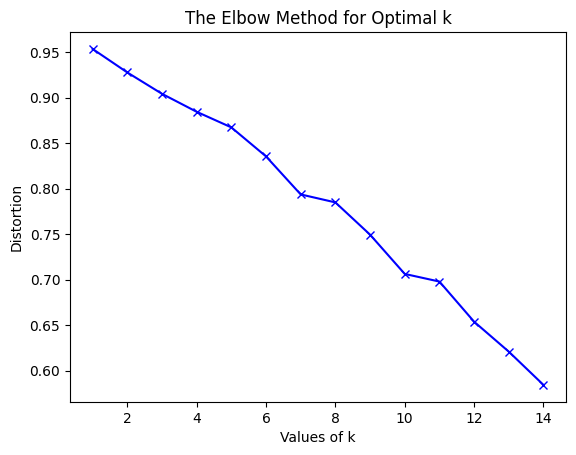

In [7]:
# Finding the optimal number of clusters using Elbow Method
def elbow_method(X, max_k = 15):
    distortions = []
    K = range(1, max_k)
    for k in K:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X)
        distortions.append(sum(np.min(cdist(X, kmeans.cluster_centers_, 'euclidean'), axis = 1)) / X.shape[0])
    
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('Values of k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method for Optimal k')
    plt.show()

elbow_method(X)

In [15]:
# Clustering and storing results
true_k = 6
kmeans = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
kmeans.fit(X)
cluster_result = pd.DataFrame({'text': cleaned_data, 'group': kmeans.predict(X)})

In [16]:
# # Clustering and storing results
# true_k = 8
# kmeans = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
# kmeans.fit(X)
# cluster_result = pd.DataFrame({'text': cleaned_data, 'group': kmeans.predict(X)})

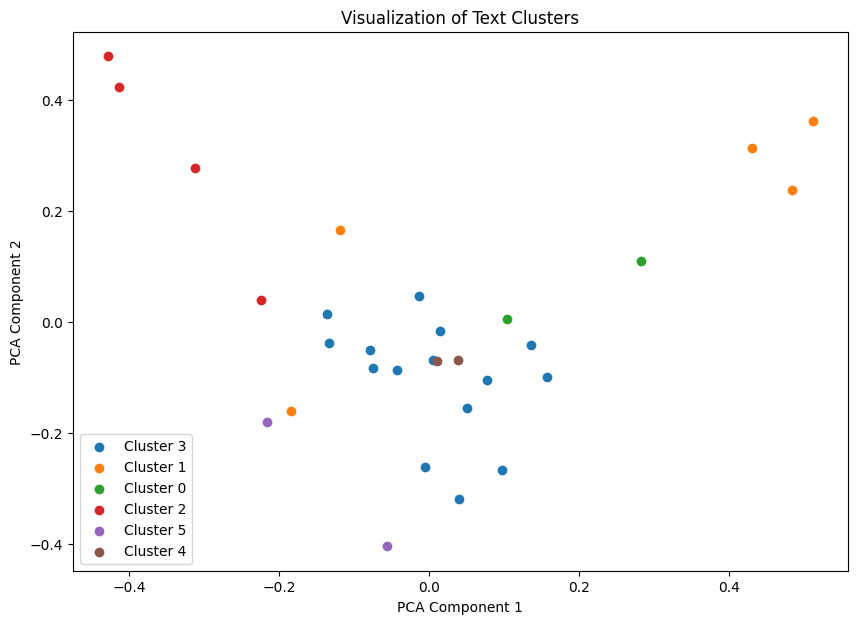

In [17]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce the feature matrix to 2 dimensions using PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)  # `X` is the transformed feature matrix from earlier

# Add the PCA components to the cluster_result DataFrame for plotting
cluster_result['PCA1'] = X_pca[:, 0]
cluster_result['PCA2'] = X_pca[:, 1]

# Plot the clusters
plt.figure(figsize=(10, 7))
for group in cluster_result['group'].unique():
    subset = cluster_result[cluster_result['group'] == group]
    plt.scatter(subset['PCA1'], subset['PCA2'], label=f'Cluster {group}')

plt.title('Visualization of Text Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()


In [18]:
import plotly.express as px
from sklearn.decomposition import PCA

In [19]:
# Reduce to 3 principal components for 3D visualization
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X)  # `X` is the transformed feature matrix from earlier

# Add the PCA components to cluster_result for 3D plotting
cluster_result['PCA1'] = X_pca_3d[:, 0]
cluster_result['PCA2'] = X_pca_3d[:, 1]
cluster_result['PCA3'] = X_pca_3d[:, 2]

# Plot a 3D scatter plot
fig = px.scatter_3d(
    cluster_result, x='PCA1', y='PCA2', z='PCA3',
    color='group',  # Color by cluster
    hover_data={'text': True},  # Display text on hover
    title="3D Visualization of Clusters"
)

# Show the plot
fig.show()


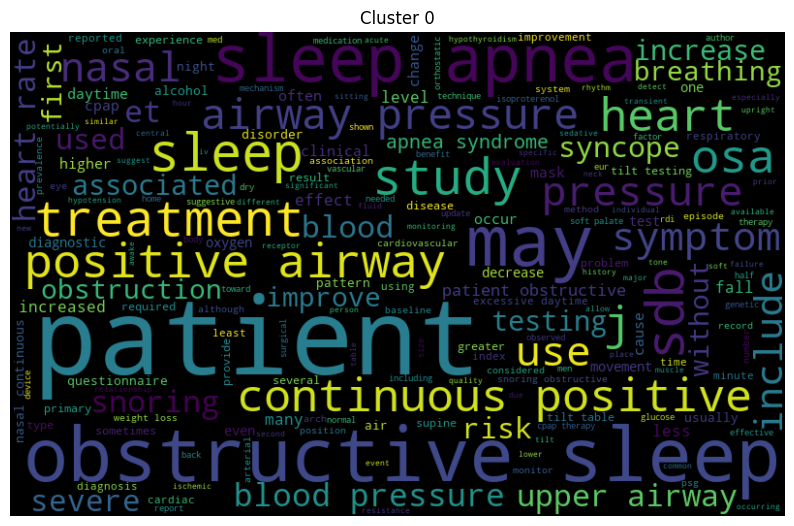

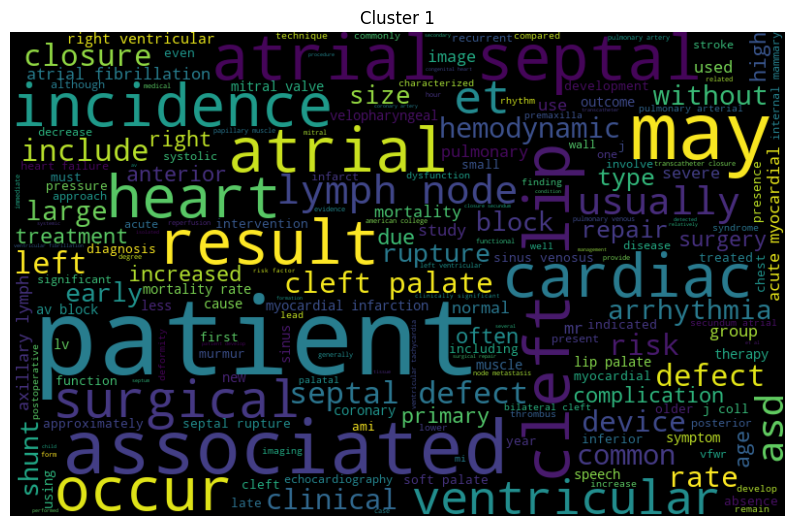

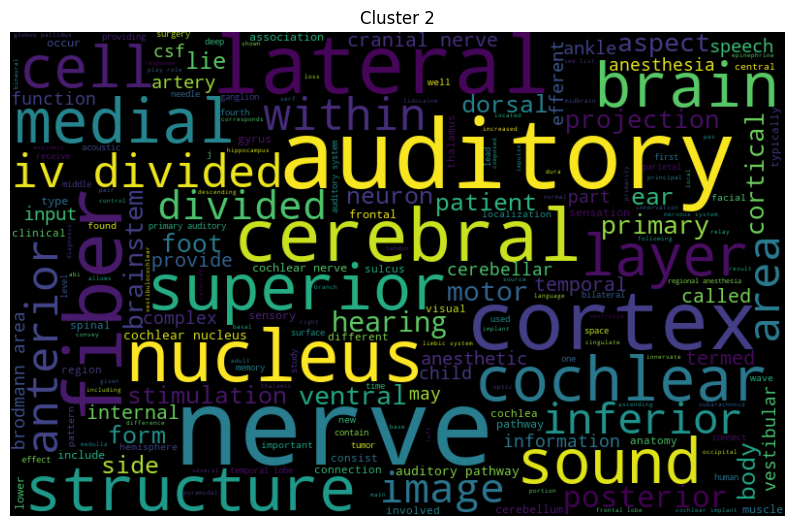

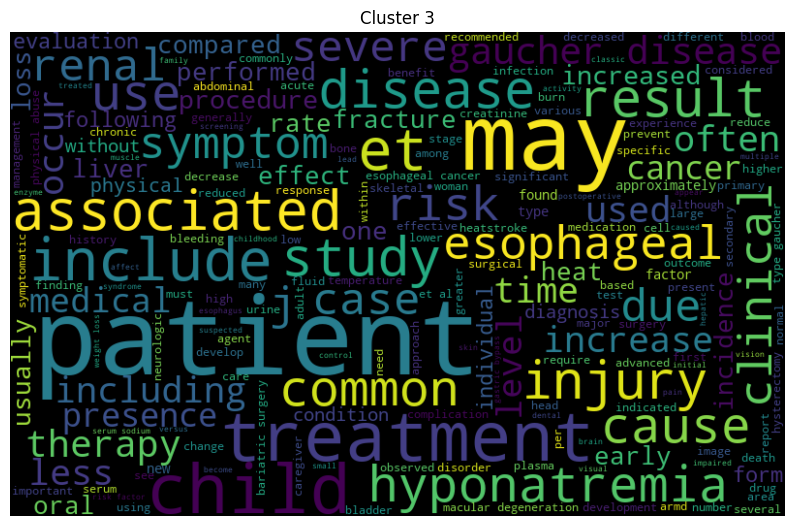

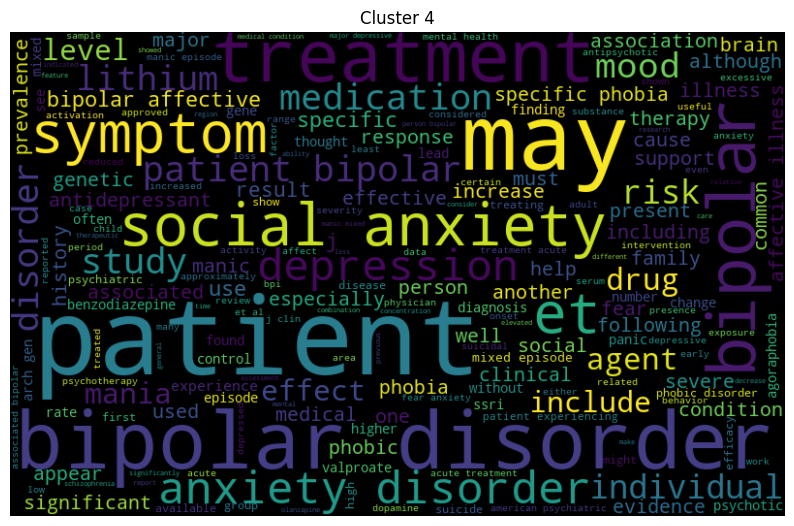

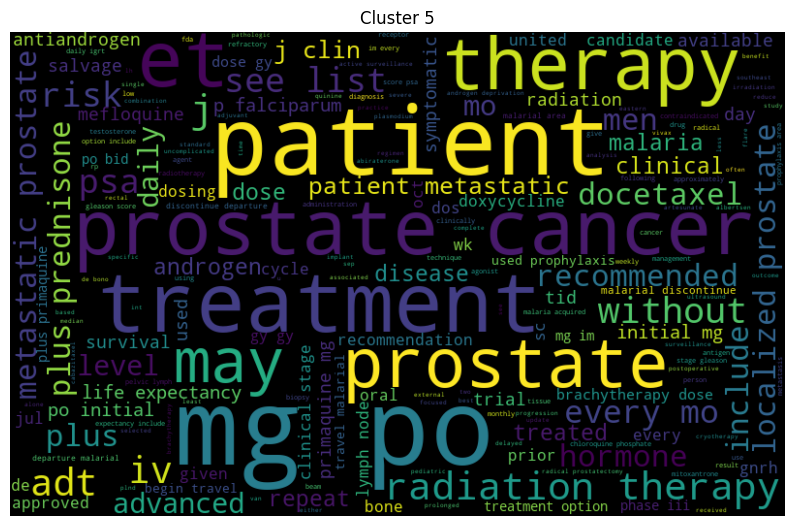

In [27]:
# Generating WordClouds for each cluster
def plot_wordclouds(data, n_clusters):
    for i in range(n_clusters):
        words = ' '.join(data.loc[data['group'] == i, 'text'])
        Wordcloud = WordCloud(width = 800, height = 500, random_state = 21, max_font_size = 110).generate(words)

        plt.figure(figsize = (10, 7))
        plt.imshow(Wordcloud, interpolation="bilinear")
        plt.axis('off')
        plt.title(f'Cluster {i}')
        plt.show()

plot_wordclouds(cluster_result, true_k)


In [28]:
# Import necessary libraries
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

# Assuming `vectorizer` is your CountVectorizer used to fit the data and `kmeans` is your trained KMeans model
# Retrieve feature names from the vectorizer
terms = vectorizer.get_feature_names_out()

# Get the order of centroids for each cluster in descending order of importance
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

# Print the top 10 words for each cluster
for i in range(kmeans.n_clusters):
    print(f"Cluster {i}:")
    for ind in order_centroids[i, :10]:  # Adjust the number here for more words per cluster
        print(f" {terms[ind]}")
    print("\n")


Cluster 0:
 sleep
 tilt
 apnea
 patient
 syncope
 heart
 obstructive
 pressure
 airway
 blood


Cluster 1:
 atrial
 cleft
 fibrillation
 lymph
 patient
 palate
 septal
 ventricular
 node
 stroke


Cluster 2:
 divided
 nerve
 auditory
 iv
 cochlear
 nucleus
 lateral
 cortex
 foot
 needle


Cluster 3:
 patient
 may
 gaucher
 creatinine
 esophageal
 tsh
 hyponatremia
 treatment
 heat
 hysterectomy


Cluster 4:
 bipolar
 anxiety
 disorder
 social
 phobia
 patient
 phobic
 fear
 depression
 treatment


Cluster 5:
 po
 mg
 prostate
 malarial
 primaquine
 plus
 malaria
 cancer
 psa
 radiation


